# CS 1164 Machine Learning - Final Project

Group Members:
- Alexander Diaz
- Gavin Wieckowski

(0) Import required dependencies for the project

In [7]:
# Setup Dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# PCA Dependencies
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

(1) Load And Clean Data

In [8]:
# import data/star_classification.csv
data = pd.read_csv('data/star_classification.csv')
data.head()

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,class,redshift,plate,MJD,fiber_ID
0,1.237661e+18,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,3606.0,301.0,2.0,79.0,6.543777e+18,GALAXY,0.634794,5812.0,56354.0,171.0
1,1.237665e+18,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,4518.0,301.0,5.0,119.0,1.176014e+19,GALAXY,0.779136,10445.0,58158.0,427.0
2,1.237661e+18,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,3606.0,301.0,2.0,120.0,5.152200e+18,GALAXY,0.644195,4576.0,55592.0,299.0
3,1.237663e+18,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,4192.0,301.0,3.0,214.0,1.030107e+19,GALAXY,0.932346,9149.0,58039.0,775.0
4,1.237680e+18,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,8102.0,301.0,3.0,137.0,6.891865e+18,GALAXY,0.116123,6121.0,56187.0,842.0


In [9]:
# Clean the data
data = data.dropna()
data = data.drop_duplicates()
cdata = data.drop(['class'], axis=1)
cdata.head()

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,redshift,plate,MJD,fiber_ID
0,1.237661e+18,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,3606.0,301.0,2.0,79.0,6.543777e+18,0.634794,5812.0,56354.0,171.0
1,1.237665e+18,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,4518.0,301.0,5.0,119.0,1.176014e+19,0.779136,10445.0,58158.0,427.0
2,1.237661e+18,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,3606.0,301.0,2.0,120.0,5.152200e+18,0.644195,4576.0,55592.0,299.0
3,1.237663e+18,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,4192.0,301.0,3.0,214.0,1.030107e+19,0.932346,9149.0,58039.0,775.0
4,1.237680e+18,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,8102.0,301.0,3.0,137.0,6.891865e+18,0.116123,6121.0,56187.0,842.0


In [10]:
# Create numeric classes for the class column
# useful for plotting
label_encoder = LabelEncoder()
numeric_classes = label_encoder.fit_transform(data['class'])

(2) Dimensionality Reduction

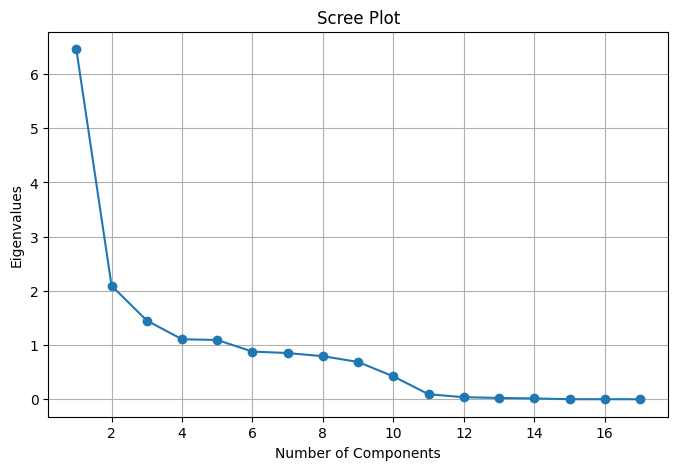

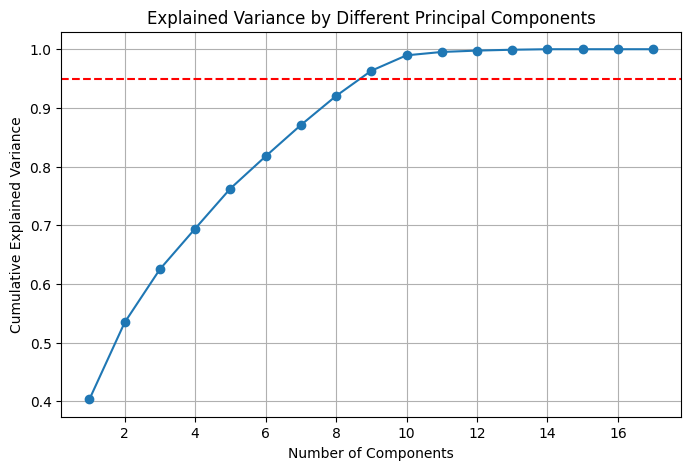

In [11]:
# Start by determining the number of principal components to use
# to retain 95% of the variance

# Standardize the Data
scaler = StandardScaler()
scaler.fit(cdata)
scaled_data = scaler.transform(cdata)

# Perform PCA without reducing dimensionality to compute full variance
pca = PCA()
pca.fit(scaled_data)

# Plot the explained variance by each component
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(pca.explained_variance_) + 1), pca.explained_variance_, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Eigenvalues')
plt.title('Scree Plot')
plt.grid(True)
plt.show()

# Calculate cumulative variance explained by all components
cumulative_variance = pca.explained_variance_ratio_.cumsum()

# Plot the cumulative explained variance
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Different Principal Components')
plt.axhline(y=0.95, color='r', linestyle='--')  # Line at 95% variance
plt.grid(True)
plt.show()

Based on the data above, we should be permforming PCA with around 8-9 components to retain our 95% variance.

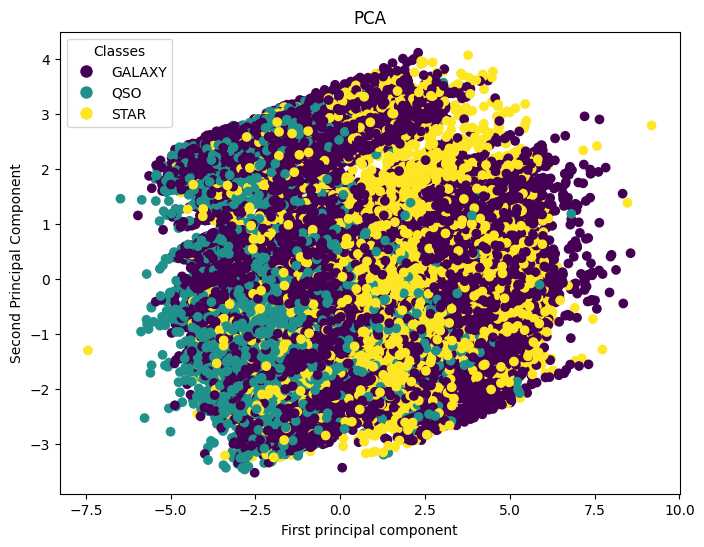

[0.40356456 0.13086337 0.09068602 0.06913483 0.0683278  0.05492296
 0.05324019 0.04959387 0.04294678]
0.9632803857642604


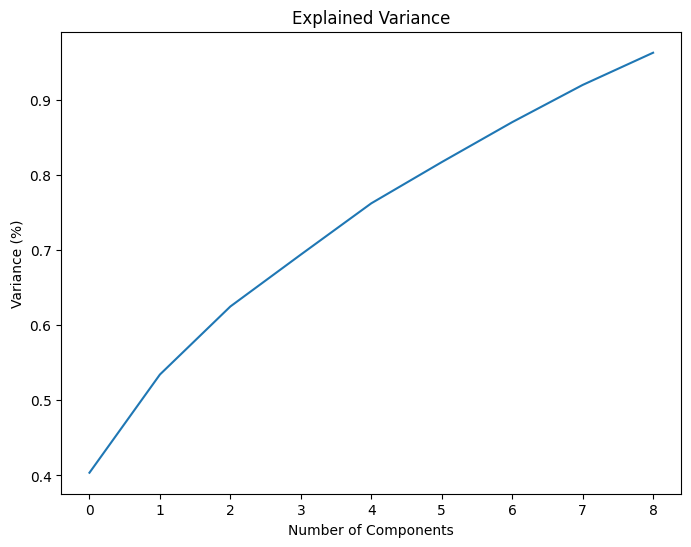

In [12]:
# PCA
pca = PCA(n_components=9)
pca.fit(scaled_data)
x_pca = pca.transform(scaled_data)

# Plot the PCA
plt.figure(figsize=(8,6))
scatter = plt.scatter(x_pca[:,0], x_pca[:,1], c=numeric_classes, cmap='viridis')
plt.xlabel('First principal component')
plt.ylabel('Second Principal Component')

# Create a legend
classes = label_encoder.classes_
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=scatter.cmap(scatter.norm(i)), markersize=10) for i in range(len(classes))]
plt.legend(handles, classes, title="Classes")
plt.title('PCA')

plt.show()

# Explained Variance
print(pca.explained_variance_ratio_)
print(pca.explained_variance_ratio_.sum())

# Plot the explained variance
plt.figure(figsize=(8,6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)')
plt.title('Explained Variance')
plt.show()


(3) Training Model

might want to do another model, this felt cheap but works pretty good

[[11662   196   471]
 [  325  3508    30]
 [ 1530    19  2908]]
              precision    recall  f1-score   support

           0       0.86      0.95      0.90     12329
           1       0.94      0.91      0.92      3863
           2       0.85      0.65      0.74      4457

    accuracy                           0.88     20649
   macro avg       0.89      0.84      0.86     20649
weighted avg       0.88      0.88      0.87     20649



<Figure size 800x600 with 0 Axes>

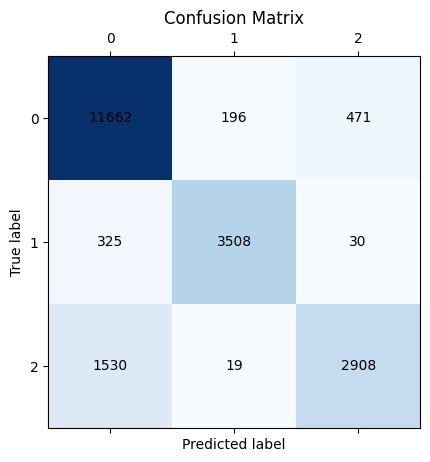

In [13]:
# neural network
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(x_pca, numeric_classes, test_size=0.3)

# Train the model
mlp = MLPClassifier(hidden_layer_sizes=(9,9,9), max_iter=1000)
mlp.fit(X_train, y_train)

# Predictions
predictions = mlp.predict(X_test)

# Evaluate the model
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))

# Plot the confusion matrix
plt.figure(figsize=(8,6))
cm = confusion_matrix(y_test, predictions)
plt.matshow(cm, cmap='Blues')

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(x=j, y=i, s=cm[i, j], va='center', ha='center')

plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()



(4) Evaluate Model

In [14]:
# evaluate the model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Accuracy
accuracy = accuracy_score(y_test, predictions)
print('Accuracy: %.2f' % accuracy)

# Precision
precision = precision_score(y_test, predictions, average='weighted')
print('Precision: %.2f' % precision)

# Recall
recall = recall_score(y_test, predictions, average='weighted')
print('Recall: %.2f' % recall)

# F1
f1 = f1_score(y_test, predictions, average='weighted')
print('F1 score: %.2f' % f1)

Accuracy: 0.88
Precision: 0.88
Recall: 0.88
F1 score: 0.87


(3) Training Model (Decision Tree)

[[10420   439  1470]
 [  433  3333    97]
 [ 1434    92  2931]]
              precision    recall  f1-score   support

           0       0.85      0.85      0.85     12329
           1       0.86      0.86      0.86      3863
           2       0.65      0.66      0.65      4457

    accuracy                           0.81     20649
   macro avg       0.79      0.79      0.79     20649
weighted avg       0.81      0.81      0.81     20649



<Figure size 800x600 with 0 Axes>

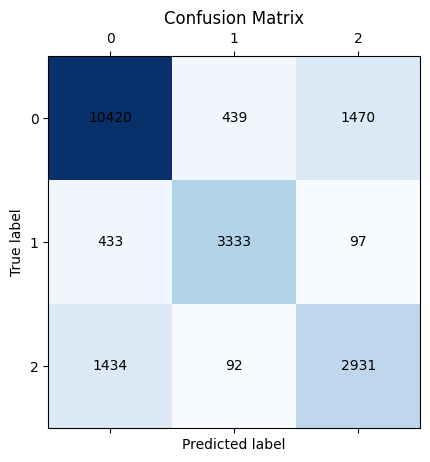

In [15]:
# decision tree
from sklearn import tree
# Train the model
clf = tree.DecisionTreeClassifier()
clf.fit(X_train, y_train)

# Predictions
predictions = clf.predict(X_test)

# Evaluate the model
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))

# Plot the confusion matrix
plt.figure(figsize=(8,6))
cm = confusion_matrix(y_test, predictions)
plt.matshow(cm, cmap='Blues')

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(x=j, y=i, s=cm[i, j], va='center', ha='center')

plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()




(4) Evaluate Model (Decision Tree)

In [16]:
# evaluate the model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Accuracy
accuracy = accuracy_score(y_test, predictions)
print('Accuracy: %.2f' % accuracy)

# Precision
precision = precision_score(y_test, predictions, average='weighted')
print('Precision: %.2f' % precision)

# Recall
recall = recall_score(y_test, predictions, average='weighted')
print('Recall: %.2f' % recall)

# F1
f1 = f1_score(y_test, predictions, average='weighted')
print('F1 score: %.2f' % f1)

Accuracy: 0.81
Precision: 0.81
Recall: 0.81
F1 score: 0.81


(3) Training Model (Support Vector Machine)

[[11880   119   330]
 [  382  3458    23]
 [ 2043    12  2402]]
              precision    recall  f1-score   support

           0       0.83      0.96      0.89     12329
           1       0.96      0.90      0.93      3863
           2       0.87      0.54      0.67      4457

    accuracy                           0.86     20649
   macro avg       0.89      0.80      0.83     20649
weighted avg       0.86      0.86      0.85     20649



<Figure size 800x600 with 0 Axes>

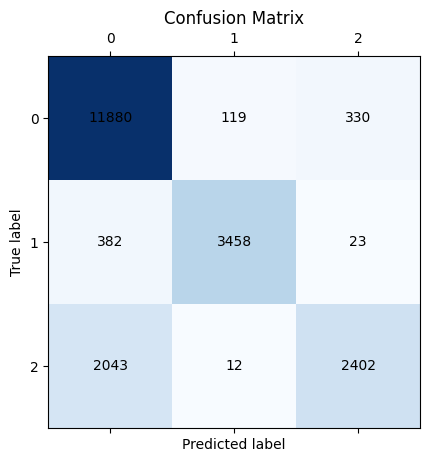

In [18]:
# support vector machine
from sklearn import svm
# Train the model
clf = svm.SVC()
clf.fit(X_train, y_train)

# Predictions
predictions = clf.predict(X_test)

# Evaluate the model
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))

# Plot the confusion matrix
plt.figure(figsize=(8,6))
cm = confusion_matrix(y_test, predictions)
plt.matshow(cm, cmap='Blues')

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(x=j, y=i, s=cm[i, j], va='center', ha='center')

plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()



(4) Evaluate Model (Support Vector Machine)

In [19]:
# evaluate the model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Accuracy
accuracy = accuracy_score(y_test, predictions)
print('Accuracy: %.2f' % accuracy)

# Precision
precision = precision_score(y_test, predictions, average='weighted')
print('Precision: %.2f' % precision)

# Recall
recall = recall_score(y_test, predictions, average='weighted')
print('Recall: %.2f' % recall)

# F1
f1 = f1_score(y_test, predictions, average='weighted')
print('F1 score: %.2f' % f1)

Accuracy: 0.86
Precision: 0.86
Recall: 0.86
F1 score: 0.85


(5) Lessons Learned

TODO...